In [ ]:
import os
os.environ["PYTHONWARNINGS"] = "ignore::DeprecationWarning"

In [ ]:
!pip install mwclient

In [ ]:
import mwclient
import itertools
import time

site = mwclient.Site("en.wikipedia.org", clients_useragent="MyBot/0.1 (hemang.agarwal2004@gmail.com)")

page = site.pages["Bitcoin"]

time.sleep(20)

# Using generator slicing to get only first 5 revisions
revs = list(itertools.islice(page.revisions(prop='ids|timestamp|user|comment'), 5))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
for rev in revs:
  print(rev)
from datetime import datetime, timezone
datetime.now(timezone.utc)

In [ ]:
# Sorting the data in reverse order
revs= sorted(revs, key=lambda rev: rev["timestamp"])

In [ ]:
# Finding setiments of the edits
# using FinBert
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

def find_sentiments(text):
  sent= sentiment_pipeline([text[:250]])[0]
  score= sent["score"]
  if sent["label"] == "NEGATIVE":
    score *= -1
  return score

In [ ]:
# Finding average sentiments per day
edits= {}
for rev in revs:
  date= time.strftime("%Y-%m-%d", rev["timestamp"])

# Can have multiple edits in a single day along with the sentiments
  if date not in edits:
    edits[date]= dict(sentiments= list(), edit_count=0)

  edits[date]["edit_count"] +=1
  comment = rev["comment"]
  edits[date]["sentiments"].append(find_sentiments(comment))

In [ ]:
!pip install statistics

In [ ]:
# To turn it into a pandas Dataframe
from statistics import mean

# Percentage of comments with negative sentiments
for key in edits:
  if len(edits[key]["sentiments"]) > 0:
    edits[key]["sentiment"]= mean(edits[key]["sentiments"])
    edits[key]["neg_sentiment"]= len([s for s in edits[key]["sentiments"] if s < 0]) / len(edits[key]["sentiments"])
  else:
    edits[key]["sentiment"] = 0
    edits[key]["neg_sentiment"] = 0

  del edits[key]["sentiments"]


In [ ]:
edits

In [ ]:
import pandas as pd
edits_df= pd.DataFrame.from_dict(edits, orient='index')
edits_df

In [ ]:
edits_df.index= pd.to_datetime(edits_df.index)

In [ ]:
from datetime import datetime

dates= pd.date_range(start="2009-03-08", end=datetime.today())    # Gives us pandas datetime index
dates

In [ ]:
edits_df = edits_df.reindex(dates, fill_value=0)

In [ ]:
edits_df

In [ ]:
rolling_edits= edits_df.rolling(30).mean()

In [ ]:
rolling_edits

In [ ]:
# Removing rows with NaN
rolling_edits= rolling_edits.dropna()

In [ ]:
rolling_edits

In [ ]:
rolling_edits.to_csv("wikipedia_edits.csv")


**Prediction Model**

In [ ]:
import yfinance as yf
import os
import pandas as pd

In [ ]:
wiki = pd.read_csv("/content/wikipedia_edits.csv", index_col=0, parse_dates=True)

# Make wiki index tz-naive
wiki.index = pd.to_datetime(wiki.index).tz_localize(None).normalize()

btc = yf.Ticker("BTC-USD").history(period="max")
btc.reset_index(inplace=True)

btc["Date"] = pd.to_datetime(btc["Date"]).dt.tz_localize(None)
btc.set_index("Date", inplace=True)
btc.index = btc.index.normalize()

del btc["Dividends"]
del btc["Stock Splits"]

btc = btc.merge(wiki, left_index=True, right_index=True, how="left")

btc[["edit_count", "sentiment", "neg_sentiment"]] = btc[
    ["edit_count", "sentiment", "neg_sentiment"]
].fillna(0)


/usr/local/lib/python3.12/dist-packages/yfinance/scrapers/history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


<Axes: xlabel='Date'>

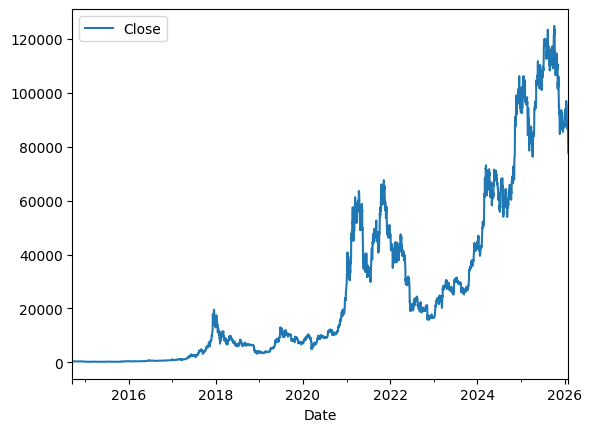

In [ ]:
btc.plot.line(y="Close", use_index=True)

In [ ]:
!pip install pandas_ta

In [ ]:
btc["Close"].dtype
btc["Close"].isna().sum()
btc["Close"].head()


Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

In [ ]:
import pandas_ta as ta

btc["RSI"] = ta.rsi(btc["Close"], length=14)

macd = ta.macd(close=btc["Close"], fast=12, slow=26, signal=9)

btc["MACD"] = macd.iloc[:, 0]   # MACD line
btc["MACD_signal"] = macd.iloc[:, 1]
btc["MACD_hist"] = macd.iloc[:, 2]

btc["EMA20"] = ta.ema(btc["Close"], length=20)
btc["EMA50"] = ta.ema(btc["Close"], length=50)
bb = ta.bbands(btc["Close"])

btc["BB_lower"] = bb.iloc[:, 0]
btc["BB_middle"] = bb.iloc[:, 1]
btc["BB_upper"] = bb.iloc[:, 2]

btc["BB_width"] = btc["BB_upper"] - btc["BB_lower"]


btc["ATR"] = ta.atr(btc["High"], btc["Low"], btc["Close"])

In [ ]:
btc.index = pd.to_datetime(btc.index)
btc = btc.sort_index()


In [ ]:
print(type(btc.index))
btc.isna().sum().sort_values(ascending=False)

<class 'pandas.DatetimeIndex'>


EMA50            49
MACD_signal      33
MACD_hist        33
MACD             25
EMA20            19
ATR              13
BB_middle         4
BB_upper          4
BB_width          4
BB_lower          4
RSI               1
Low               0
High              0
Open              0
neg_sentiment     0
Close             0
Volume            0
edit_count        0
sentiment         0
dtype: int64

In [ ]:
btc["Return"] = btc["Close"].pct_change().shift(-1)
btc["Target"] = (btc["Return"] > 0).astype(int)
btc

,Open,High,Low,Close,Volume,edit_count,sentiment,neg_sentiment,RSI,MACD,...,MACD_hist,EMA20,EMA50,BB_lower,BB_middle,BB_upper,BB_width,ATR,Return,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0.000000,0.000000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.071926,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.000000,0.000000,0.0,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.069843,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.000000,0.000000,0.0,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035735,1
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.000000,0.000000,0.0,3.215775,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024659,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.000000,0.000000,0.0,3.138104,NaN,...,NaN,NaN,NaN,366.152732,416.859003,467.565274,101.412542,NaN,0.008352,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-28,89104.046875,90439.289062,88721.460938,89184.570312,39807419296,0.166667,0.043762,0.0,45.563768,-666.014753,...,-179.660559,90276.399251,91256.839148,86220.009142,88447.446875,90674.884608,4454.875465,2313.692690,-0.051836,0
2026-01-29,89169.851562,89200.781250,83250.601562,84561.585938,64653083162,0.166667,0.043762,0.0,34.403718,-1031.598482,...,-350.048143,89732.131317,90994.280199,83602.837210,87537.617188,91472.397165,7869.559954,2573.441762,-0.005120,0
2026-01-30,84562.726562,84602.164062,81071.476562,84128.656250,72083816087,0.166667,0.043762,0.0,33.574375,-1340.804074,...,-548.199330,89198.467025,90725.040044,82051.173756,87048.904688,92046.635619,9995.461863,2641.816457,-0.065466,0


In [ ]:
predictors = ["Open","High","Low","Close","Volume",
              "edit_count","sentiment","neg_sentiment",
              "RSI","MACD","EMA20","EMA50","BB_width","ATR"]


In [ ]:
btc = btc.dropna(subset=predictors + ["Target"])
btc

,Open,High,Low,Close,Volume,edit_count,sentiment,neg_sentiment,RSI,MACD,...,MACD_hist,EMA20,EMA50,BB_lower,BB_middle,BB_upper,BB_width,ATR,Return,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-05,330.683014,343.368988,330.683014,339.485992,19817200,0.000000,0.000000,0.0,37.379565,-13.927914,...,-12.784074,350.004907,372.766840,318.388239,329.834595,341.280950,22.892711,15.194851,0.028879,1
2014-11-06,339.458008,352.966003,338.424011,349.290009,18797000,0.000000,0.000000,0.0,42.486886,-12.268993,...,-12.681058,349.936822,371.846180,314.997871,334.542798,354.087724,39.089853,15.148218,-0.019683,0
2014-11-07,349.817993,352.731995,341.776001,342.415009,16834200,0.000000,0.000000,0.0,40.021827,-11.377884,...,-12.420423,349.220458,370.692017,320.112193,337.847400,355.582606,35.470413,14.848774,0.008974,1
2014-11-08,342.153992,347.032013,342.153992,345.488007,8535470,0.000000,0.000000,0.0,41.651412,-10.304920,...,-11.997322,348.864987,369.703624,327.199169,341.434204,355.669239,28.470070,14.136577,0.051452,1
2014-11-09,345.376007,363.626007,344.255005,363.264008,24205600,0.000000,0.000000,0.0,50.097616,-7.928815,...,-11.183621,350.236322,369.451090,329.424016,347.988605,366.553194,37.129178,14.510464,0.010075,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-28,89104.046875,90439.289062,88721.460938,89184.570312,39807419296,0.166667,0.043762,0.0,45.563768,-666.014753,...,-179.660559,90276.399251,91256.839148,86220.009142,88447.446875,90674.884608,4454.875465,2313.692690,-0.051836,0
2026-01-29,89169.851562,89200.781250,83250.601562,84561.585938,64653083162,0.166667,0.043762,0.0,34.403718,-1031.598482,...,-350.048143,89732.131317,90994.280199,83602.837210,87537.617188,91472.397165,7869.559954,2573.441762,-0.005120,0
2026-01-30,84562.726562,84602.164062,81071.476562,84128.656250,72083816087,0.166667,0.043762,0.0,33.574375,-1340.804074,...,-548.199330,89198.467025,90725.040044,82051.173756,87048.904688,92046.635619,9995.461863,2641.816457,-0.065466,0


In [ ]:
train= btc.iloc[:-200]
test= btc.iloc[-200:]
train

,Open,High,Low,Close,Volume,edit_count,sentiment,neg_sentiment,RSI,MACD,...,MACD_hist,EMA20,EMA50,BB_lower,BB_middle,BB_upper,BB_width,ATR,Return,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-05,330.683014,343.368988,330.683014,339.485992,19817200,0.0,0.0,0.0,37.379565,-13.927914,...,-12.784074,350.004907,372.766840,318.388239,329.834595,341.280950,22.892711,15.194851,0.028879,1
2014-11-06,339.458008,352.966003,338.424011,349.290009,18797000,0.0,0.0,0.0,42.486886,-12.268993,...,-12.681058,349.936822,371.846180,314.997871,334.542798,354.087724,39.089853,15.148218,-0.019683,0
2014-11-07,349.817993,352.731995,341.776001,342.415009,16834200,0.0,0.0,0.0,40.021827,-11.377884,...,-12.420423,349.220458,370.692017,320.112193,337.847400,355.582606,35.470413,14.848774,0.008974,1
2014-11-08,342.153992,347.032013,342.153992,345.488007,8535470,0.0,0.0,0.0,41.651412,-10.304920,...,-11.997322,348.864987,369.703624,327.199169,341.434204,355.669239,28.470070,14.136577,0.051452,1
2014-11-09,345.376007,363.626007,344.255005,363.264008,24205600,0.0,0.0,0.0,50.097616,-7.928815,...,-11.183621,350.236322,369.451090,329.424016,347.988605,366.553194,37.129178,14.510464,0.010075,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-12,117530.710938,118219.898438,116977.023438,117435.226562,45524560304,0.0,0.0,0.0,72.791105,2515.876863,...,1488.534533,110177.575584,106841.284319,106466.992081,114243.250000,122019.507919,15552.515838,2653.442208,0.014313,1
2025-07-13,117432.203125,119449.570312,117265.437500,119116.117188,49021091807,0.0,0.0,0.0,75.116329,2907.438952,...,1772.315417,111028.865260,107322.650313,110315.668367,116276.418750,122237.169133,11921.500766,2619.920108,0.006159,1
2025-07-14,119115.789062,123091.609375,118959.195312,119849.703125,181746419401,0.0,0.0,0.0,76.077194,3239.604836,...,2065.773301,111868.945057,107813.907286,114936.555005,117981.048438,121025.541870,6088.986865,2727.955390,-0.017293,0


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=1
)

rf_model.fit(train[predictors], train["Return"])


RandomForestRegressor(max_depth=8, n_estimators=200, random_state=1)

In [ ]:
rf_preds = rf_model.predict(test[predictors])

In [ ]:
rf_signals = (rf_preds > 0.002).astype(int)
rf_strategy = (1 + rf_signals * test["Return"]).cumprod()


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
)


In [ ]:
xgb_model.fit(train[predictors], train["Return"])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
xgb_preds = xgb_model.predict(test[predictors])
xgb_preds = pd.Series(xgb_preds, index=test.index, name="Predicted_Return")


In [ ]:
threshold = 0.002  # 0.2% expected return

xgb_signals = (xgb_preds > threshold).astype(int)


In [ ]:

xgb_df = pd.DataFrame({
    "Pred": xgb_preds,
    "Return": test["Return"]
}).dropna()

xgb_df["Signal"] = (xgb_df["Pred"] > threshold).astype(int)
xgb_df["Strategy_Return"] = xgb_df["Signal"] * xgb_df["Return"]

xgb_equity = (1 + xgb_df["Strategy_Return"]).cumprod()
buyhold = (1 + xgb_df["Return"]).cumprod()


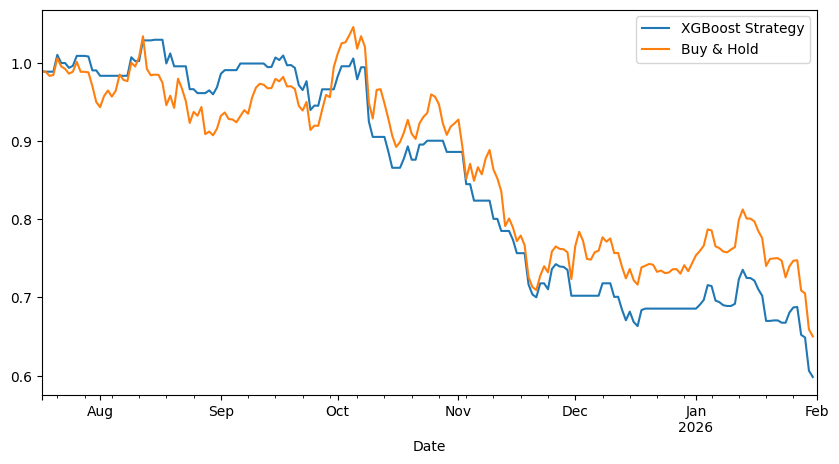

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
xgb_equity.plot(label="XGBoost Strategy")
buyhold.plot(label="Buy & Hold")
plt.legend()
plt.show()


In [ ]:
xgb_equity.iloc[-1]
buyhold.iloc[-1]


np.float64(nan)

In [ ]:
# Directional accuracy
direction_pred = (xgb_preds > 0).astype(int)
direction_true = (test["Return"] > 0).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(direction_true, direction_pred))
print("Precision:", precision_score(direction_true, direction_pred))
print("Recall:", recall_score(direction_true, direction_pred))
print("F1:", f1_score(direction_true, direction_pred))


Accuracy: 0.48
Precision: 0.4573643410852713
Recall: 0.6344086021505376
F1: 0.5315315315315315


In [ ]:
naive_pred = (test["Return"].shift(1) > 0).astype(int)

print("Naive accuracy:", accuracy_score(direction_true[1:], naive_pred[1:]))


Naive accuracy: 0.5276381909547738


In [ ]:
import numpy as np

strategy_returns = xgb_signals * test["Return"]

sharpe = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)
max_dd = (xgb_equity / xgb_equity.cummax() - 1).min()

print("Sharpe Ratio:", sharpe)
print("Max Drawdown:", max_dd)


Sharpe Ratio: -2.5452373560596224
Max Drawdown: -0.4188397743634289


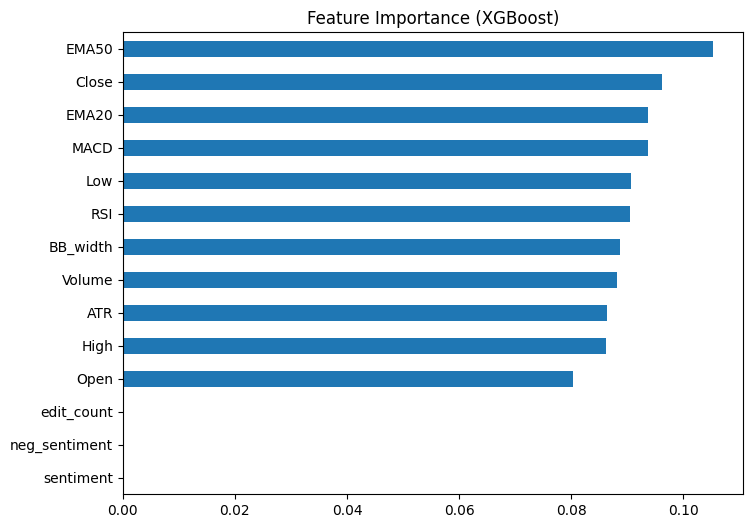

In [ ]:
import matplotlib.pyplot as plt

feat_imp = pd.Series(xgb_model.feature_importances_, index=predictors)
feat_imp.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance (XGBoost)")
plt.show()


In [ ]:
# Adding LTSM
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [ ]:
lstm_features = ["Close", "Volume", "RSI", "MACD", "EMA20", "EMA50", "BB_width", "ATR",
                 "edit_count", "sentiment"]


In [ ]:
split_idx = int(0.8 * len(btc))

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(btc[lstm_features].iloc[:split_idx])
scaled_test = scaler.transform(btc[lstm_features].iloc[split_idx:])

scaled_data = np.vstack([scaled_train, scaled_test])


In [ ]:
def create_sequences(data, target, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(target[i])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_data, btc["Return"].values, window=30)


In [ ]:
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [ ]:
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0031 - val_loss: nan
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: nan
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: nan
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: nan
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: nan
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: nan
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: nan
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: nan
Epoch 9/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: nan
Epoch 10/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: nan
Epoch 11/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: nan
Epoch 12/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: na

In [ ]:
lstm_preds = model_lstm.predict(X_test_lstm).flatten()


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
lstm_index = btc.index[-len(lstm_preds):]
lstm_preds = pd.Series(lstm_preds, index=lstm_index, name="LSTM_Pred")


In [ ]:
lstm_signals = (lstm_preds > 0).astype(int)


In [ ]:
lstm_df = pd.DataFrame({
    "Pred": lstm_preds,
    "Return": btc.loc[lstm_index, "Return"]
}).dropna()


In [ ]:
lstm_df["Signal"] = (lstm_df["Pred"] > 0).astype(int)
lstm_df["Strategy_Return"] = lstm_df["Signal"] * lstm_df["Return"]

lstm_equity = (1 + lstm_df["Strategy_Return"]).cumprod()
buyhold = (1 + lstm_df["Return"]).cumprod()


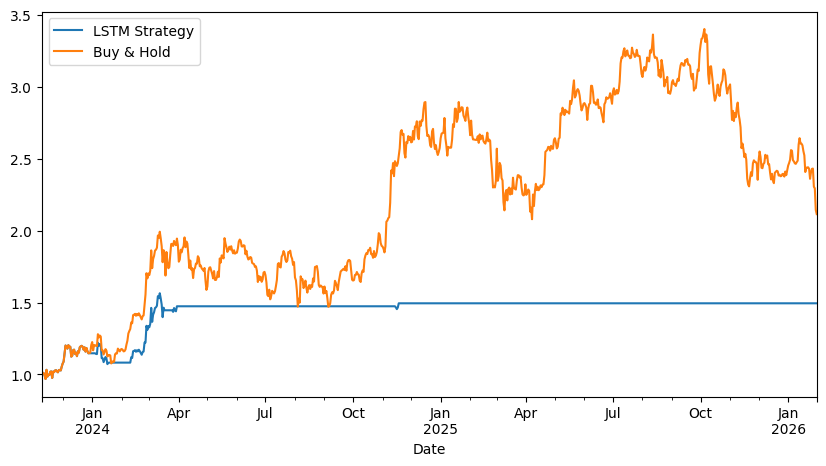

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
lstm_equity.plot(label="LSTM Strategy")
buyhold.plot(label="Buy & Hold")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

direction_true = (btc.loc[lstm_index, "Return"] > 0).astype(int)
direction_pred = (lstm_preds > 0).astype(int)

print("LSTM Direction Accuracy:", accuracy_score(direction_true, direction_pred))


LSTM Direction Accuracy: 0.49754901960784315


In [ ]:
accuracy_score(direction_true, direction_pred)


0.49754901960784315

In [ ]:
direction_pred_xgb = (xgb_preds > 0).astype(int)
direction_true_xgb = (test["Return"] > 0).astype(int)

print("XGB Accuracy:", accuracy_score(direction_true_xgb, direction_pred_xgb))


XGB Accuracy: 0.48


In [ ]:
lstm_equity.iloc[-1], buyhold.iloc[-1]


(np.float64(1.494550114352085), np.float64(2.1140329847212525))

In [ ]:
baseline_df = pd.DataFrame({
    "True": (test["Return"] > 0).astype(int),
    "Naive": (test["Return"].shift(1) > 0).astype(int)
}).dropna()

from sklearn.metrics import accuracy_score

print("Naive Accuracy:", accuracy_score(baseline_df["True"], baseline_df["Naive"]))


Naive Accuracy: 0.53


In [ ]:
model_df = pd.DataFrame({
    "True": (test["Return"] > 0).astype(int),
    "Pred": (xgb_preds > 0).astype(int)
}).dropna()

print("Model Accuracy:", accuracy_score(model_df["True"], model_df["Pred"]))


Model Accuracy: 0.48


In [ ]:
print("Naive Accuracy:", accuracy_score(baseline_df["True"], baseline_df["Naive"]))
print("Model Accuracy:", accuracy_score(model_df["True"], model_df["Pred"]))


Naive Accuracy: 0.53
Model Accuracy: 0.48


In [ ]:
from sklearn.metrics import accuracy_score

direction_true_lstm = (lstm_df["Return"] > 0).astype(int)
direction_pred_lstm = (lstm_df["Pred"] > 0).astype(int)

print("LSTM Accuracy:", accuracy_score(direction_true_lstm, direction_pred_lstm))


LSTM Accuracy: 0.49693251533742333


In [ ]:
print("Final Equity (XGB):", xgb_equity.iloc[-1])
print("Final Equity (BuyHold):", buyhold.iloc[-1])


Final Equity (XGB): nan
Final Equity (BuyHold): 2.1140329847212525


In [ ]:
print("LSTM Accuracy:", accuracy_score(direction_true_lstm, direction_pred_lstm))


LSTM Accuracy: 0.49693251533742333


Rsme for regression

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_df = pd.DataFrame({
    "True": test["Return"],
    "XGB": xgb_preds,
    "RF": rf_preds
}).dropna()

rmse_xgb = np.sqrt(mean_squared_error(rmse_df["True"], rmse_df["XGB"]))
rmse_rf = np.sqrt(mean_squared_error(rmse_df["True"], rmse_df["RF"]))

print("XGB RMSE:", rmse_xgb)
print("RF RMSE:", rmse_rf)


XGB RMSE: 0.022563859256085013
RF RMSE: 0.020603405330949127


In [ ]:
# Sharpe for LSTM
lstm_strategy_returns = lstm_df["Strategy_Return"]

lstm_sharpe = (lstm_strategy_returns.mean() / lstm_strategy_returns.std()) * np.sqrt(252)
lstm_max_dd = (lstm_equity / lstm_equity.cummax() - 1).min()

print("LSTM Sharpe:", lstm_sharpe)
print("LSTM Max Drawdown:", lstm_max_dd)


LSTM Sharpe: 0.8487354841959751
LSTM Max Drawdown: -0.12153255421516607


In [ ]:
results = pd.DataFrame({
    "Accuracy": [
        accuracy_score(direction_true_xgb, direction_pred_xgb),
        accuracy_score(direction_true_lstm, direction_pred_lstm),
        accuracy_score(baseline_df["True"], baseline_df["Naive"])
    ],
    "Final Equity": [
        xgb_equity.iloc[-1],
        lstm_equity.iloc[-1],
        buyhold.iloc[-1]
    ]
}, index=["XGBoost", "LSTM", "Naive"])

results


,Accuracy,Final Equity
XGBoost,0.480000,0.598313
LSTM,0.496933,1.494550
Naive,0.530000,0.650269


In [ ]:
def sharpe_ratio(returns):
    return (returns.mean() / returns.std()) * np.sqrt(252)

print("XGB Sharpe:", sharpe_ratio(xgb_df["Strategy_Return"]))
print("LSTM Sharpe:", sharpe_ratio(lstm_df["Strategy_Return"]))
print("Naive Sharpe:", sharpe_ratio(baseline_df["True"]*0 + baseline_df["Naive"]))  # or recompute naive strategy


XGB Sharpe: -2.5452373560596224
LSTM Sharpe: 0.8487354841959751
Naive Sharpe: 14.762550497670155


Models based on technical indicators and sentiment show limited directional predictability for daily Bitcoin returns.
However, sequence-based LSTM models can extract patterns that improve trading performance relative to baselines, even when classification accuracy is similar.

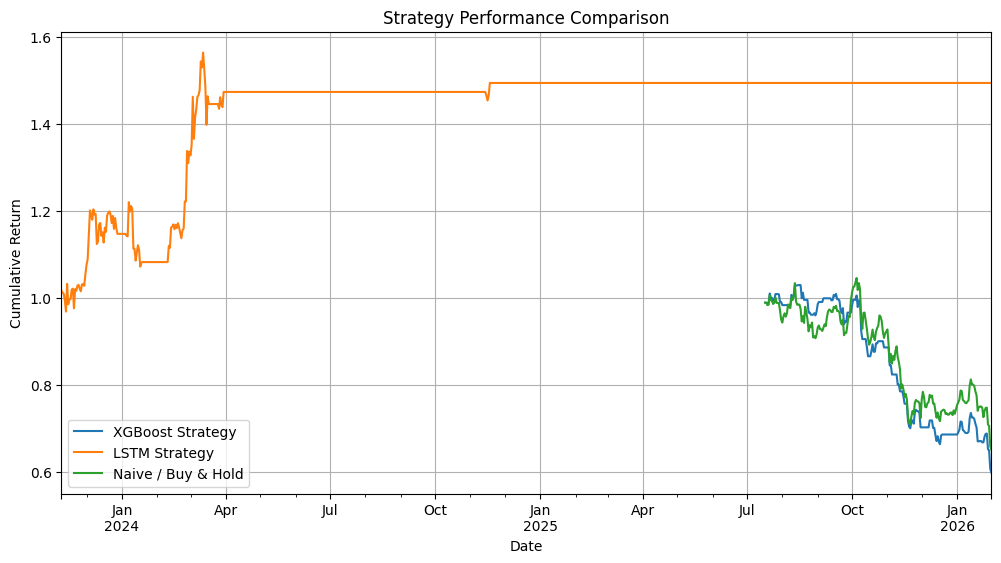

In [ ]:
plt.figure(figsize=(12,6))

xgb_equity.plot(label="XGBoost Strategy")
lstm_equity.plot(label="LSTM Strategy")
buyhold.plot(label="Naive / Buy & Hold")

plt.title("Strategy Performance Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


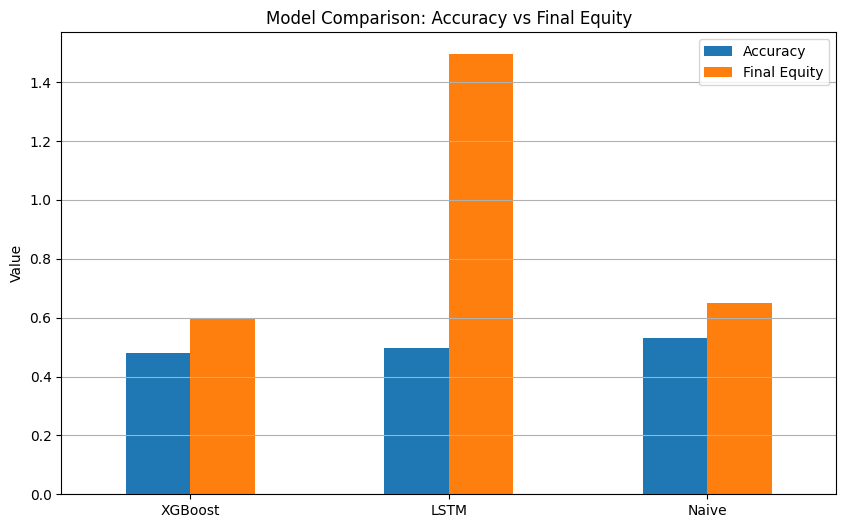

In [ ]:
results = pd.DataFrame({
    "Accuracy": [0.48, 0.496933, 0.53],
    "Final Equity": [0.598313, 1.494550, 0.650269]
}, index=["XGBoost", "LSTM", "Naive"])

results.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison: Accuracy vs Final Equity")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


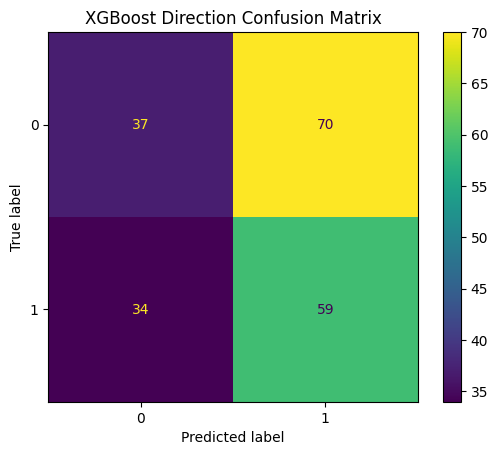

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(direction_true_xgb, direction_pred_xgb)
plt.title("XGBoost Direction Confusion Matrix")
plt.show()
